In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
data = pd.read_csv('nvda_long_data.csv')

In [3]:
data

,Date,Close,High,Low,Open,Volume
0,1999-01-22,0.037615,0.044779,0.035585,0.040122,2714688000
1,1999-01-25,0.041556,0.042033,0.037615,0.040600,510480000
2,1999-01-26,0.038331,0.042869,0.037734,0.042033,343200000
3,1999-01-27,0.038212,0.039406,0.036301,0.038451,244368000
4,1999-01-28,0.038092,0.038451,0.037854,0.038212,227520000
...,...,...,...,...,...,...
6541,2025-01-23,147.220001,147.229996,143.720001,145.050003,155915500
6542,2025-01-24,142.619995,148.970001,141.880005,148.369995,234657600
6543,2025-01-27,118.419998,128.399994,116.699997,124.800003,818830900
6544,2025-01-28,128.990005,129.000000,116.250000,121.809998,579666400


In [4]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [5]:
data

,Close,High,Low,Open,Volume
Date,,,,,
1999-01-22,0.037615,0.044779,0.035585,0.040122,2714688000
1999-01-25,0.041556,0.042033,0.037615,0.040600,510480000
1999-01-26,0.038331,0.042869,0.037734,0.042033,343200000
1999-01-27,0.038212,0.039406,0.036301,0.038451,244368000
1999-01-28,0.038092,0.038451,0.037854,0.038212,227520000
...,...,...,...,...,...
2025-01-23,147.220001,147.229996,143.720001,145.050003,155915500
2025-01-24,142.619995,148.970001,141.880005,148.369995,234657600
2025-01-27,118.419998,128.399994,116.699997,124.800003,818830900


In [6]:
# check the frequency
print(data.index.freq)

None


In [7]:
# Set the frequency to daily
data = data.resample('D').ffill()

In [8]:
print(data.index.freq)

<Day>


In [9]:
# check for missing
data.isnull().sum()

,0
Close,0
High,0
Low,0
Open,0
Volume,0


## Stationarity Check

In [10]:
# Perform ADF test
result = adfuller(data['Close'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

# Interpret the result
if result[1] <= 0.05:
    print("The data is stationary (reject the null hypothesis).")
else:
    print("The data is non-stationary (fail to reject the null hypothesis).")

ADF Statistic: 4.0868896415612985
p-value: 1.0
Critical Values:
   1%: -3.431041007202659
   5%: -2.861845382181689
   10%: -2.56693254983586
The data is non-stationary (fail to reject the null hypothesis).


In [11]:
# Apply differencing
data['Close_diff'] = data['Close'].diff().dropna()

In [12]:
data

,Close,High,Low,Open,Volume,Close_diff
Date,,,,,,
1999-01-22,0.037615,0.044779,0.035585,0.040122,2714688000,NaN
1999-01-23,0.037615,0.044779,0.035585,0.040122,2714688000,0.000000
1999-01-24,0.037615,0.044779,0.035585,0.040122,2714688000,0.000000
1999-01-25,0.041556,0.042033,0.037615,0.040600,510480000,0.003941
1999-01-26,0.038331,0.042869,0.037734,0.042033,343200000,-0.003224
...,...,...,...,...,...,...
2025-01-25,142.619995,148.970001,141.880005,148.369995,234657600,0.000000
2025-01-26,142.619995,148.970001,141.880005,148.369995,234657600,0.000000
2025-01-27,118.419998,128.399994,116.699997,124.800003,818830900,-24.199997


In [17]:
# drop Na from close_diff
data.dropna(inplace=True)

In [18]:
# Use only the 'Close_diff' column
data = data[['Close_diff']]

In [19]:
data

,Close_diff
Date,
1999-01-23,0.000000
1999-01-24,0.000000
1999-01-25,0.003941
1999-01-26,-0.003224
1999-01-27,-0.000119
...,...
2025-01-25,0.000000
2025-01-26,0.000000
2025-01-27,-24.199997


## Train-Test split

In [20]:
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Models

## ARIMA

### Determine ARIMA Parameters:

In [13]:
!pip install pmdarima

In [21]:
from pmdarima import auto_arima

model_arima = auto_arima(train['Close_diff'], seasonal=False, trace=True)
print(model_arima.summary())

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-27315.000, Time=6.33 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-27207.216, Time=0.33 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-27260.838, Time=0.20 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-27282.465, Time=2.84 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-27256.838, Time=2.08 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-27289.964, Time=8.40 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-27315.442, Time=6.83 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-27303.560, Time=6.77 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,4)(0,0,0)[0]             : AIC=-27301.519, Time=11.17 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-27303.651, Time=7.63 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-27305.832, Time=16.61 sec

Best model:  ARIMA(2,0,3)(0,0,0)[0]          
Total fit time: 88.929 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 7603
Model:               SARIMAX(2, 0, 3)   Log Likelihood               13663.721
Date:                Wed, 05 Feb 2025   AIC                         -27315.442
Time:                        09:21:55   BIC                         -27273.825
Sample:                    01-23-1999   HQIC                        -27301.161
                         - 11-16-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4931      0.024     61.276      0.000       1.

# Fit ARIMA Model:

In [22]:
model = ARIMA(train['Close_diff'], order=(2, 0, 3))
fitted_model = model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Forecaast and Evaluate

In [24]:
# Generate forecasts using the fitted ARIMA model
arima_forecast = fitted_model.predict(start=test.index[0], end=test.index[-1])

mae_arima = mean_absolute_error(test['Close_diff'], arima_forecast)
# Calculate MSE first, then take the square root for RMSE
mse_arima = mean_squared_error(test['Close_diff'], arima_forecast)
rmse_arima = np.sqrt(mse_arima)  # Calculate RMSE using NumPy
print(f'ARIMA MAE: {mae_arima}, RMSE: {rmse_arima}')

ARIMA MAE: 0.6662028296406249, RMSE: 1.566660441644436


# LSTM Model

## Preprocess Data for LSTM

In [25]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train[['Close_diff']])

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X_train, y_train = create_sequences(scaled_train, seq_length)

## Build LSTM Model:

In [26]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model_lstm.add(LSTM(50))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Train LSTM Model

In [27]:
model_lstm.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 28s 68ms/step - loss: 0.0273
Epoch 2/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - loss: 9.1659e-04
Epoch 3/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - loss: 7.9295e-04
Epoch 4/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - loss: 6.8851e-04
Epoch 5/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - loss: 8.1175e-04
Epoch 6/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - loss: 0.0012
Epoch 7/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - loss: 8.2119e-04
Epoch 8/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - loss: 8.2912e-04
Epoch 9/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - loss: 8.2081e-04
Epoch 10/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - loss: 8.2944e-04


## Forecast and Evaluate

In [28]:
scaled_test = scaler.transform(test[['Close_diff']])
X_test, y_test = create_sequences(scaled_test, seq_length)
predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(predictions)

58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step


In [30]:
mae_lstm = mean_absolute_error(test[seq_length:], predictions)
rmse_lstm = np.sqrt(mean_squared_error(test[seq_length:], predictions))
print(f'LSTM MAE: {mae_lstm}, RMSE: {rmse_lstm}')

LSTM MAE: 0.7148922681808472, RMSE: 1.6029604137622955


# Prophet Model

## Prepare Data for Prophet

In [31]:
train_prophet = train.reset_index()[['Date', 'Close_diff']].rename(columns={'Date': 'ds', 'Close': 'y'})

## Fit Prophet Model

In [32]:
from prophet import Prophet

train_prophet = train.reset_index()[['Date', 'Close_diff']].rename(columns={'Date': 'ds', 'Close_diff': 'y'})

# Remove timezone information from the 'ds' column
train_prophet['ds'] = train_prophet['ds'].dt.tz_localize(None)

model_prophet = Prophet()
model_prophet.fit(train_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp13d2y01n/u9mf07ze.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp13d2y01n/ui28qmbv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77975', 'data', 'file=/tmp/tmp13d2y01n/u9mf07ze.json', 'init=/tmp/tmp13d2y01n/ui28qmbv.json', 'output', 'file=/tmp/tmp13d2y01n/prophet_modelj66art7j/prophet_model-20250205092912.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:29:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:29:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


## Forecast and Evaluate:

In [33]:
future = model_prophet.make_future_dataframe(periods=len(test), freq='H')
forecast = model_prophet.predict(future)
forecast = forecast.iloc[-len(test):]

/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


Prophet MAE: 0.6667158501819008


In [37]:
# evaluate with MAE and RMSE
mae = mean_absolute_error(test['Close_diff'], forecast['yhat'])
rmse = np.sqrt(mean_squared_error(test['Close_diff'], forecast['yhat']))
print('Prophet MAE:', mae)
print('Prophet RMSE:', rmse)

Prophet MAE: 0.6667158501819008
Prophet RMSE: 1.5665678322777918


# Compare Models

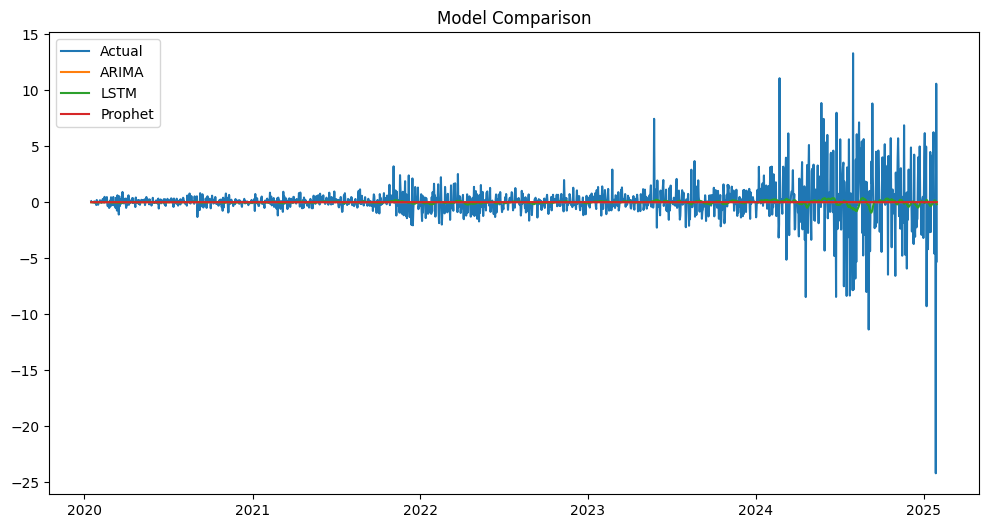

In [38]:
# Adjust the plotting to use the same range for all data
plt.figure(figsize=(12, 6))

# Slice test['Close'] to match the length of predictions for LSTM
plt.plot(test.index[seq_length:], test['Close_diff'].iloc[seq_length:], label='Actual')

plt.plot(test.index[seq_length:], arima_forecast[seq_length:], label='ARIMA')

plt.plot(test.index[seq_length:], predictions[:, 0], label='LSTM')  # Extract the first column of predictions

plt.plot(test.index[seq_length:], forecast['yhat'].iloc[seq_length:], label='Prophet')  # Slice forecast['yhat']

plt.legend()
plt.title('Model Comparison')
plt.show()

In [39]:
# compare the model in tabel form
models = ['ARIMA', 'LSTM', 'Prophet']
maes = [mae_arima, mae_lstm, mae]
rmses = [rmse_arima, rmse_lstm, rmse]


In [40]:
data = {'Model': models, 'MAE': maes, 'RMSE': rmses}
df_compare = pd.DataFrame(data)

print(df_compare)

     Model       MAE      RMSE
0    ARIMA  0.666203  1.566660
1     LSTM  0.714892  1.602960
2  Prophet  0.666716  1.566568
